# Explain PyTorch MobileNetV2 using the `Partition` explainer

In this example we are explaining the output of MobileNetV2 for classifying images into 1000 ImageNet classes.

In [1]:
import json

import numpy as np
import torch
import torchvision

import shap

### Loading Model and Data

In [ ]:
# Choosing the best device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using device:  cpu


In [ ]:
# Load the model
model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
# Send the model to the device
model.to(device)
# Set the model to evaluation mode
model.eval()
# Retrive the model's inputs and outputs
X, y = shap.datasets.imagenet50()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (50, 224, 224, 3)
y shape: (50,)


In [26]:
# Getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))
print("Class names:", class_names)

Number of ImageNet classes: 1000
Class names: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba'

In [5]:
# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [6]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

In [7]:
# Check that transformations work correctly
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[1:3])
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [132 814]: ['American_egret' 'speedboat']


### Explain one image

In [8]:
topk = 4
batch_size = 50
n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[1:2],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:36, 96.87s/it]               


In [9]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 224, 224, 3]), (1, 224, 224, 3, 4))

In [10]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

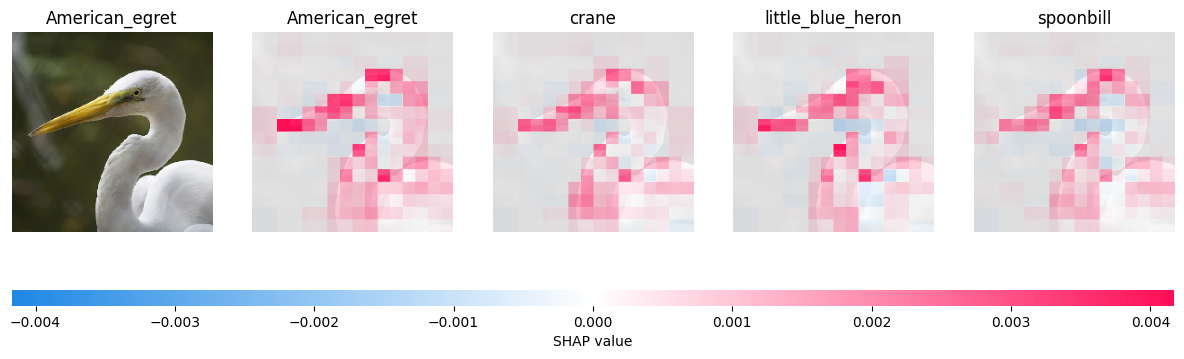

In [11]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[132]],
)

### Explain multiple images

In [12]:
# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[1:4],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [03:04<00:00, 46.11s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [04:41, 93.74s/it]                       


In [13]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([3, 224, 224, 3]), (3, 224, 224, 3, 4))

In [14]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]

In [15]:
(shap_values.data.shape, shap_values.values[0].shape)

((3, 224, 224, 3), (3, 224, 224, 3))

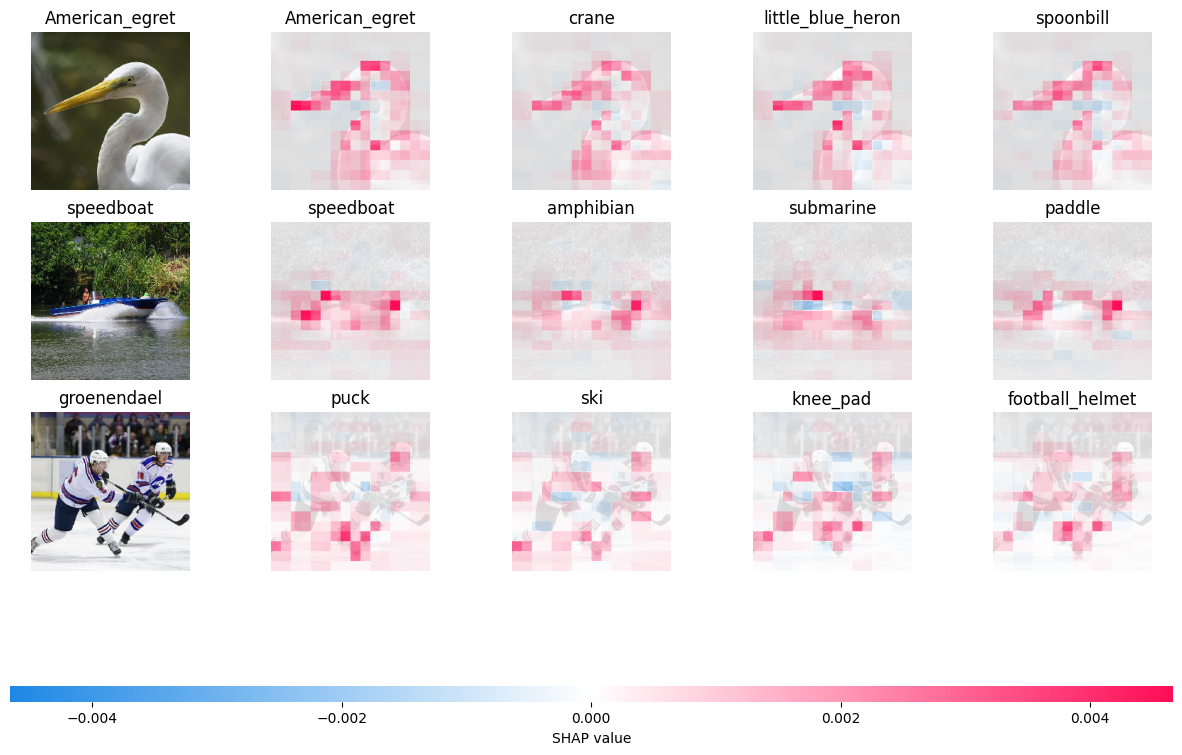

In [28]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[132], class_names[814], class_names[224]],
)